## Réseau à modèles imbriqués

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

## True function

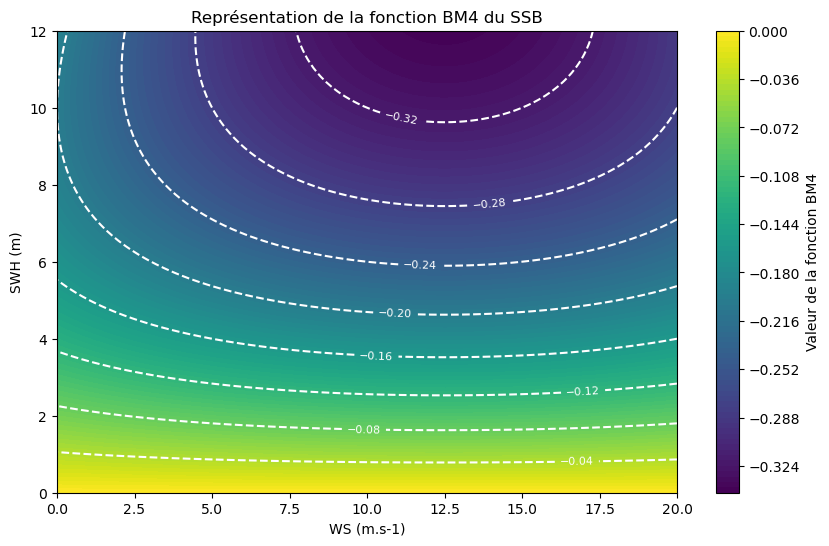

In [48]:
def function(v1, v2):
    a1 = -0.04
    a2 = 0.002
    a3 = -0.002
    a4 = 8*(1e-5)
    return v2 * (a1 + a2 * v2 + a3 * v1 + a4 * (v1 ** 2))

# Créer une grille de valeurs pour x1 et x2
v1_values = np.linspace(0, 20, 100)
v2_values = np.linspace(0, 12, 100)
v1_grid, v2_grid = np.meshgrid(v1_values, v2_values)

# Calculer les valeurs de y pour chaque combinaison de x1 et x2
y_grid = function(v1_grid, v2_grid)

# Tracer les résultats avec une colorbar continue
plt.figure(figsize=(10, 6))
cp = plt.contourf(v1_grid, v2_grid, y_grid, cmap='viridis', levels=100)
cbar = plt.colorbar(cp)
cbar.ax.set_ylabel('Valeur de la fonction BM4')

# Ajouter des courbes de niveaux
contours = plt.contour(v1_grid, v2_grid, y_grid, colors='white', levels=10)
plt.clabel(contours, inline=True, fontsize=8)

plt.xlabel('WS (m.s-1)')
plt.ylabel('SWH (m)')
plt.title('Représentation de la fonction BM4 du SSB')
plt.show()

## True dataset

In [49]:
# Spécifiez le chemin du fichier .dat dans votre Google Drive
file_path = '/data/SSB_ETU/HLAFARGUE/DATASET_NGAN/dataset_equal_tirage1perbox.dat'
#file_path = '/data/SSB_ETU/HLAFARGUE/DATASET_NGAN/dataset_tirage_random_parcyc.dat'

# Chargement du fichier .dat dans un DataFrame
data = pd.read_csv(file_path, sep='\s+', header=None)
column_names = ['SWH2', 'WS2', 'SWH1', 'WS1', 'Delta_SSH']
data.columns = column_names

# Affichage des premières lignes du DataFrame avec les noms de colonnes
print(data.head())


    SWH2    WS2   SWH1     WS1  Delta_SSH
0  0.732  0.120  2.550   9.715      0.032
1  0.966  0.161  3.450  11.929      0.100
2  1.145  0.097  1.301   4.275      0.053
3  1.424  0.128  1.350   5.737     -0.031
4  1.524  0.122  1.381   1.982     -0.011


In [50]:
data.describe()

,SWH2,WS2,SWH1,WS1,Delta_SSH
count,56744.000000,56744.000000,56744.000000,56744.000000,56744.000000
mean,4.145546,10.317656,3.259200,9.065882,-0.024338
std,2.084666,5.438556,1.549936,3.976422,0.100945
min,0.052000,0.003000,0.087000,0.005000,-0.499000
25%,2.516750,5.939750,2.109000,6.149000,-0.083000
50%,4.021000,10.262000,3.041000,8.691000,-0.021000
75%,5.659000,14.753000,4.183000,11.627000,0.037000
max,10.879000,20.999000,10.798000,20.993000,0.496000


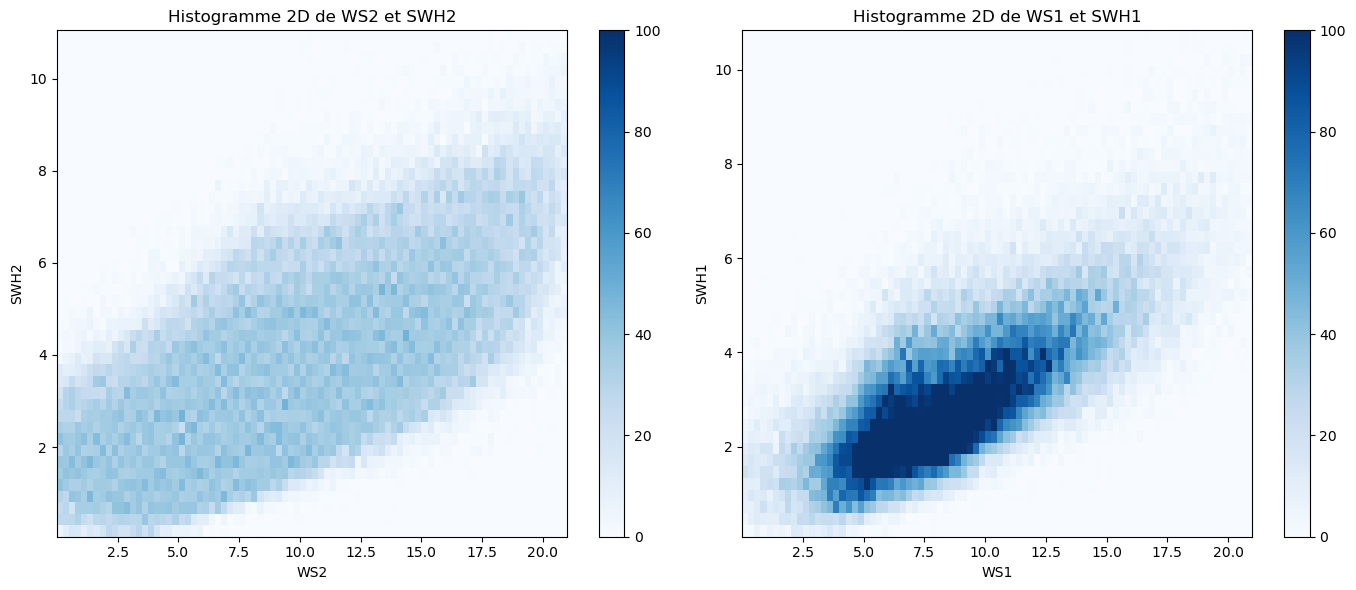

In [51]:
# Déterminer les limites des données pour définir les boîtes de 0.25x0.25
x_min, x_max = data['WS2'].min(), data['WS2'].max()
y_min, y_max = data['SWH2'].min(), data['SWH2'].max()

# Créer les bin edges avec des intervalles de 0.25
x_bins = np.arange(x_min, x_max + 0.25, 0.25)
y_bins = np.arange(y_min, y_max + 0.25, 0.25)

# Créer les histogrammes 2D avec les boîtes de 0.25x0.25
plt.figure(figsize=(14, 6))

# Histogramme 2D pour WS2 et SWH2
plt.subplot(1, 2, 1)
plt.hist2d(data['WS2'], data['SWH2'], bins=[x_bins, y_bins], cmap='Blues', vmax=100)
plt.colorbar()
plt.xlabel('WS2')
plt.ylabel('SWH2')
plt.title('Histogramme 2D de WS2 et SWH2')

# Déterminer les limites des données pour SWH1 et WS1
x_min, x_max = data['WS1'].min(), data['WS1'].max()
y_min, y_max = data['SWH1'].min(), data['SWH1'].max()

# Créer les bin edges avec des intervalles de 0.25
x_bins = np.arange(x_min, x_max + 0.25, 0.25)
y_bins = np.arange(y_min, y_max + 0.25, 0.25)

# Histogramme 2D pour WS1 et SWH1
plt.subplot(1, 2, 2)
plt.hist2d(data['WS1'], data['SWH1'], bins=[x_bins, y_bins], cmap='Blues', vmax=100)
plt.colorbar()
plt.xlabel('WS1')
plt.ylabel('SWH1')
plt.title('Histogramme 2D de WS1 et SWH1')

plt.tight_layout()
plt.show()

## Prepare data

In [52]:
# Créer les nouvelles DataFrames X1 et X2
X1 = data[['WS1', 'SWH1']]
X2 = data[['WS2', 'SWH2']]

# Affichage des premières lignes de X1 et X2 pour vérifier
print("X1:")
print(X1.head())

print("X2:")
print(X2.head())

X1:
      WS1   SWH1
0   9.715  2.550
1  11.929  3.450
2   4.275  1.301
3   5.737  1.350
4   1.982  1.381
X2:
     WS2   SWH2
0  0.120  0.732
1  0.161  0.966
2  0.097  1.145
3  0.128  1.424
4  0.122  1.524


In [53]:
# Calculer Delta_ssh
Delta_ssh = data[['Delta_SSH']].values

# Calculer w_init1
w_init1 = function(X2['WS2'].values, X2['SWH2'].values)

In [54]:
class CustomDataset(Dataset):
    def __init__(self, X1, X2, Delta_ssh, w_init1):
        self.X1 = torch.tensor(X1, dtype=torch.float32)
        self.X2 = torch.tensor(X2, dtype=torch.float32)
        self.Delta_ssh = torch.tensor(Delta_ssh, dtype=torch.float32)
        self.w_init1 = torch.tensor(w_init1, dtype=torch.float32)

    def __len__(self):
        return len(self.X1)

    def __getitem__(self, idx):
        return {
            'X1': self.X1[idx],
            'X2': self.X2[idx],
            'Delta_ssh': self.Delta_ssh[idx],
            'w_init1': self.w_init1[idx]
        }

In [55]:
def prepare_data_train_val_test(X1, X2, Delta_ssh, w_init1, batch_size=32):
    # Standardiser les données
    scaler1 = StandardScaler()
    X1_scaled = scaler1.fit_transform(X1)
    scaler2 = StandardScaler()
    X2_scaled = scaler2.fit_transform(X2)

    mean_1, scale_1 = scaler1.mean_, scaler1.scale_
    mean_2, scale_2 = scaler2.mean_, scaler2.scale_

    # Diviser les données en ensembles d'entraînement, de validation et de test
    X1_train, X1_temp, X2_train, X2_temp, Delta_train, Delta_temp, w_train, w_temp = train_test_split(
        X1_scaled, X2_scaled, Delta_ssh, w_init1, test_size=0.3, random_state=42)

    X1_val, X1_test, X2_val, X2_test, Delta_val, Delta_test, w_val, w_test = train_test_split(
        X1_temp, X2_temp, Delta_temp, w_temp, test_size=0.5, random_state=42)

    # Créer les datasets PyTorch
    train_dataset = CustomDataset(X1_train, X2_train, Delta_train, w_train)
    val_dataset = CustomDataset(X1_val, X2_val, Delta_val, w_val)
    test_dataset = CustomDataset(X1_test, X2_test, Delta_test, w_test)

    # Créer les DataLoaders PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, mean_1, scale_1, mean_2, scale_2

# Préparer les DataLoaders
train_loader, val_loader, test_loader, mean_1, scale_1, mean_2, scale_2 = prepare_data_train_val_test(X1, X2, Delta_ssh, w_init1, batch_size=32)

# Afficher les formes des ensembles pour vérification
print("Nombre de batchs dans train_loader:", len(train_loader))
print("Nombre de batchs dans val_loader:", len(val_loader))
print("Nombre de batchs dans test_loader:", len(test_loader))

Nombre de batchs dans train_loader: 1242
Nombre de batchs dans val_loader: 266
Nombre de batchs dans test_loader: 266


In [56]:
def prepare_all_data(X1, X2, Delta_ssh, w_init1, batch_size=32):
    # Standardiser les données
    scaler1 = StandardScaler()
    X1_scaled = scaler1.fit_transform(X1)
    scaler2 = StandardScaler()
    X2_scaled = scaler2.fit_transform(X2)

    mean_1, scale_1 = scaler1.mean_, scaler1.scale_
    mean_2, scale_2 = scaler2.mean_, scaler2.scale_

    # Créer le dataset PyTorch
    all_dataset = CustomDataset(X1_scaled, X2_scaled, Delta_ssh, w_init1)

    # Créer les DataLoaders PyTorch
    loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True)

    return loader, mean_1, scale_1, mean_2, scale_2

# Préparer le DataLoader
loader, mean_1, scale_1, mean_2, scale_2 = prepare_all_data(X1, X2, Delta_ssh, w_init1, batch_size=32)

## Model definition

In [57]:
class SubModel(nn.Module):
    def __init__(self, input_dim):
        super(SubModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output(x)
        return x

class ParallelModel(nn.Module):
    def __init__(self, nb_var):
        super(ParallelModel, self).__init__()
        self.submodel1 = SubModel(nb_var)
        self.submodel2 = SubModel(nb_var)

    def forward(self, X1, X2):
        y1 = self.submodel1(X1)
        y2 = self.submodel2(X2)
        return y1, y2

In [58]:
nb_var = 2
model = ParallelModel(nb_var)
print(model)

ParallelModel(
  (submodel1): SubModel(
    (layer1): Linear(in_features=2, out_features=64, bias=True)
    (layer2): Linear(in_features=64, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=1, bias=True)
  )
  (submodel2): SubModel(
    (layer1): Linear(in_features=2, out_features=64, bias=True)
    (layer2): Linear(in_features=64, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [59]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        # Xavier initialization for the weights
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        # Constant initialization for the biases
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

Explication

- Type de Couche :

La fonction vérifie si le module passé (m) est une couche linéaire (nn.Linear). Si c'est le cas, elle applique une initialisation spécifique aux poids et aux biais de cette couche.


- Initialisation Xavier (He) des Poids :

nn.init.kaiming_uniform_ : Il s'agit d'une initialisation basée sur la méthode He (ou Kaiming), qui initialise les poids selon une distribution uniforme.

Cette méthode est particulièrement adaptée pour les réseaux utilisant des fonctions d'activation ReLU (Rectified Linear Unit). Elle aide à maintenir la variance des gradients à travers les couches, ce qui permet un entraînement plus stable et plus rapide.

L'argument nonlinearity='relu' indique que cette initialisation est optimisée pour les activations de type ReLU.


- Initialisation Constante des Biais :

nn.init.constant_ : Cette fonction initialise les biais à une valeur constante, ici 0.0.

Initialiser les biais à zéro est une pratique courante qui simplifie l'apprentissage, car cela n'introduit pas de biais initial dans les activations des neurones.

## Training and validation

In [66]:
# Initialiser le modèle, les optimiseurs et la perte
nb_var = 2
model = ParallelModel(nb_var)
model.apply(init_weights)
learning_rate = 0.09
optimizer1 = optim.SGD(model.submodel1.parameters(), lr=learning_rate)
optimizer2 = optim.SGD(model.submodel2.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

#### Version avec critère de convergence par phase

In [67]:
import time

# Listes pour enregistrer les valeurs de perte
train_losses1 = []
train_losses2 = []

# Listes pour enregistrer les valeurs de perte
train_losses1_phase1 = []
train_losses2_phase2 = []
train_losses1_phase3 = []
train_losses2_phase3 = []

# Critères de convergence
stop_criteria1 = 1e-4
stop_criteria2 = 1e-4
stop_criteria_alternated = 1e-6

# Variables pour les temps et les compteurs d'époques
start_time = time.time()
epoch_phase1 = 0
epoch_phase2 = 0
epoch_phase3 = 0

# Phase 1
while True:
    model.train()
    epoch_loss1 = 0
    for batch in loader:
        X1 = batch['X1']
        X2 = batch['X2']
        delta_ssh = batch['Delta_ssh']
        w_init1 = batch['w_init1']

        y1, _ = model(X1, X2)
        optimizer1.zero_grad()
        loss1 = criterion(delta_ssh.unsqueeze(1), w_init1.unsqueeze(1) - y1)
        loss1.backward(retain_graph=True)
        optimizer1.step()
        epoch_loss1 += loss1.item()
    
    avg_train_loss1 = epoch_loss1 / len(loader)
    train_losses1.append(avg_train_loss1)
    train_losses1_phase1.append(avg_train_loss1)
    epoch_phase1 += 1
    print(f'Phase 1 - Epoch [{epoch_phase1}], Train Loss1: {avg_train_loss1:.8f}')
    
    if avg_train_loss1 < stop_criteria1:
        print(f'Phase 1 completed at epoch {epoch_phase1} as Train Loss1 reached {avg_train_loss1:.8f}')
        break

# Phase 2
while True:
    model.train()
    epoch_loss2 = 0
    for batch in loader:
        X1 = batch['X1']
        X2 = batch['X2']
        delta_ssh = batch['Delta_ssh']

        y1, y2 = model(X1, X2)
        optimizer2.zero_grad()
        loss2 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
        loss2.backward()
        optimizer2.step()
        epoch_loss2 += loss2.item()
    
    avg_train_loss2 = epoch_loss2 / len(loader)
    train_losses2_phase2.append(avg_train_loss2)
    epoch_phase2 += 1
    print(f'Phase 2 - Epoch [{epoch_phase2}], Train Loss2: {avg_train_loss2:.8f}')
    
    if avg_train_loss2 < stop_criteria2:
        print(f'Phase 2 completed at epoch {epoch_phase2} as Train Loss2 reached {avg_train_loss2:.8f}')
        break

# Phase 3
while True:
    model.train()
    epoch_loss1 = 0
    epoch_loss2 = 0
    for batch in loader:
        X1 = batch['X1']
        X2 = batch['X2']
        delta_ssh = batch['Delta_ssh']

        # Forward pass for both sub-models
        y1, y2 = model(X1, X2)

        # Calcul de la perte pour SubModel1
        optimizer1.zero_grad()
        loss1 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
        loss1.backward(retain_graph=True)
        optimizer1.step()
        epoch_loss1 += loss1.item()

        # Forward pass for both sub-models
        y1, y2 = model(X1, X2)
        # Calcul de la perte pour SubModel2
        optimizer2.zero_grad()
        loss2 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
        loss2.backward()
        optimizer2.step()
        epoch_loss2 += loss2.item()
    
    avg_train_loss1 = epoch_loss1 / len(loader)
    avg_train_loss2 = epoch_loss2 / len(loader)
    train_losses1_phase3.append(avg_train_loss1)
    train_losses2_phase3.append(avg_train_loss2)
    epoch_phase3 += 1
    print(f'Phase 3 - Epoch [{epoch_phase3}], Train Loss1: {avg_train_loss1:.8f}, Train Loss2: {avg_train_loss2:.8f}')
    
    if avg_train_loss1 < stop_criteria_alternated and avg_train_loss2 < stop_criteria_alternated:
        print(f'Phase 3 completed at epoch {epoch_phase3} as both Train Loss1 and Train Loss2 reached {avg_train_loss1:.8f} and {avg_train_loss2:.8f} respectively')
        break

end_time = time.time()
total_time = end_time - start_time

print(f'Total training time: {total_time:.2f} seconds')
print(f'Number of epochs for phase 1 (initialization): {epoch_phase1}')
print(f'Number of epochs for phase 2: {epoch_phase2}')
print(f'Number of epochs for phase 3 (alternating): {epoch_phase3}')

## Validation
# model.eval()
# val_loss1 = 0
# val_loss2 = 0
# with torch.no_grad():
#     for batch in val_loader:
#         X1 = batch['X1']
#         X2 = batch['X2']
#         delta_ssh = batch['Delta_ssh']
#         y1, y2 = model(X1, X2)
#         loss1 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
#         loss2 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
#         val_loss1 += loss1.item()
#         val_loss2 += loss2.item()

# avg_val_loss1 = val_loss1 / len(val_loader)
# avg_val_loss2 = val_loss2 / len(val_loader)
# val_losses1.append(avg_val_loss1)
# val_losses2.append(avg_val_loss2)s
# print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss1: {avg_val_loss1:.4f}, Val Loss2: {avg_val_loss2:.4f}')


Phase 1 - Epoch [1], Train Loss1: 0.02601197
Phase 1 - Epoch [2], Train Loss1: 0.01355838
Phase 1 - Epoch [3], Train Loss1: 0.01351501
Phase 1 - Epoch [4], Train Loss1: 0.01347474
Phase 1 - Epoch [5], Train Loss1: 0.01348401
Phase 1 - Epoch [6], Train Loss1: 0.01345402
Phase 1 - Epoch [7], Train Loss1: 0.01347079
Phase 1 - Epoch [8], Train Loss1: 0.01344608
Phase 1 - Epoch [9], Train Loss1: 0.01344530
Phase 1 - Epoch [10], Train Loss1: 0.01342186
Phase 1 - Epoch [11], Train Loss1: 0.01342103
Phase 1 - Epoch [12], Train Loss1: 0.01341707
Phase 1 - Epoch [13], Train Loss1: 0.01340475
Phase 1 - Epoch [14], Train Loss1: 0.01343198
Phase 1 - Epoch [15], Train Loss1: 0.01340802
Phase 1 - Epoch [16], Train Loss1: 0.01340292
Phase 1 - Epoch [17], Train Loss1: 0.01339406
Phase 1 - Epoch [18], Train Loss1: 0.01339700
Phase 1 - Epoch [19], Train Loss1: 0.01338674
Phase 1 - Epoch [20], Train Loss1: 0.01337340
Phase 1 - Epoch [21], Train Loss1: 0.01338453
Phase 1 - Epoch [22], Train Loss1: 0.013377

KeyboardInterrupt: 

In [68]:
def plot_losses(train_losses1_phase1, train_losses1_phase3, train_losses2_phase2, train_losses2_phase3):
    # Création de la figure et des axes
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Phase 1 - Train Loss 1
    epochs_phase1 = range(1, len(train_losses1_phase1) + 1)
    axs[0, 0].plot(epochs_phase1, train_losses1_phase1, label='Train Loss 1 (Phase 1)')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_ylim(0, 0.002)
    axs[0, 0].set_title('Training Loss 1 (Phase 1)')
    axs[0, 0].legend()

    # Phase 2 - Train Loss 2
    epochs_phase2 = range(1, len(train_losses2_phase2) + 1)
    axs[0, 1].plot(epochs_phase2, train_losses2_phase2, label='Train Loss 2 (Phase 2)')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 0].set_ylim(0, 0.002)
    axs[0, 1].set_title('Training Loss 2 (Phase 2)')
    axs[0, 1].legend()
    
    # Phase 3 - Train Loss 1 et 2
    epochs_phase3 = range(1, len(train_losses1_phase3) + 1)
    axs[1, 0].plot(epochs_phase3, train_losses1_phase3, label='Train Loss 1 (Phase 3)')
    axs[1, 0].plot(epochs_phase3, train_losses2_phase3, label='Train Loss 2 (Phase 3)')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].set_xlim(0, len(train_losses1_phase3))
    axs[1, 0].set_ylim(0, 10.e-5)
    axs[1, 0].set_title('Training Loss 1 et 2 (Phase 3)')
    axs[1, 0].legend()

    # Zoom sur Phase 3 - Train Loss 1 et 2
    axs[1, 1].plot(epochs_phase3, train_losses1_phase3, label='Train Loss 1 (Phase 3)')
    axs[1, 1].plot(epochs_phase3, train_losses2_phase3, label='Train Loss 2 (Phase 3)')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].set_title('Zoom on Training Loss 1 et 2 (Phase 3)')
    axs[1, 1].set_xlim(0, len(train_losses1_phase3))
    axs[1, 1].set_ylim(0, 10.e-5)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_5396/1717273886.py:29: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[1, 0].set_xlim(0, len(train_losses1_phase3))
/tmp/ipykernel_5396/1717273886.py:40: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[1, 1].set_xlim(0, len(train_losses1_phase3))


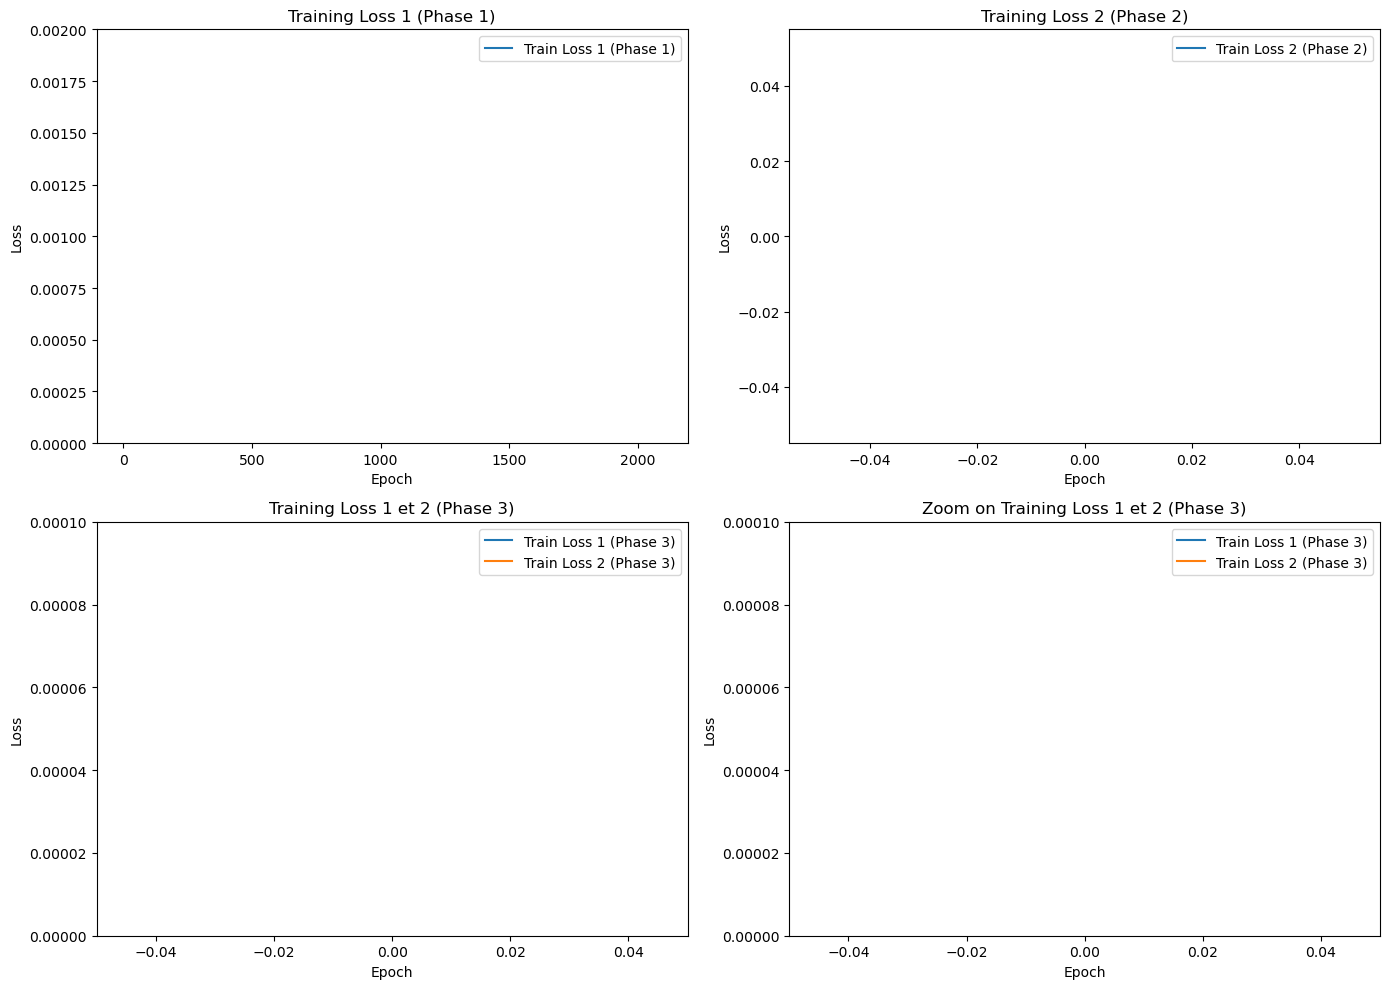

In [69]:
# Affichage des pertes
plot_losses(train_losses1_phase1, train_losses1_phase3, train_losses2_phase2, train_losses2_phase3)

#### Version avec arrêt au nb d'itération donnée en entrée

In [35]:
# Boucle d'entraînement
num_epochs = 300

# Listes pour enregistrer les valeurs de perte
train_losses1 = []
train_losses2 = []
#val_losses1 = []
#val_losses2 = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    epoch_loss1 = 0
    epoch_loss2 = 0
    for batch in loader: #train_loader:
        X1 = batch['X1']
        X2 = batch['X2']
        delta_ssh = batch['Delta_ssh']
        w_init1 = batch['w_init1']

        # Initialisation
        if epoch <= 100:
            y1, _ = model(X1, X2)
            optimizer1.zero_grad()
            loss1 = criterion(delta_ssh.unsqueeze(1), w_init1.unsqueeze(1) - y1)
            loss1.backward(retain_graph=True)
            optimizer1.step()
            epoch_loss1 += loss1.item()

        elif epoch > 100 and epoch <= 200:
            y1, y2 = model(X1, X2)
            optimizer2.zero_grad()
            loss2 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
            loss2.backward()
            optimizer2.step()
            epoch_loss2 += loss2.item()

        else:
            # Forward pass for both sub-models
            y1, y2 = model(X1, X2)

            # Calcul de la perte pour SubModel1
            optimizer1.zero_grad()
            loss1 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
            loss1.backward(retain_graph=True)
            optimizer1.step()
            epoch_loss1 += loss1.item()

            # Forward pass for both sub-models
            y1, y2 = model(X1, X2)
            # Calcul de la perte pour SubModel2
            optimizer2.zero_grad()
            loss2 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
            loss2.backward()
            optimizer2.step()
            epoch_loss2 += loss2.item()

    avg_train_loss1 = epoch_loss1 / len(loader)#len(train_loader)
    avg_train_loss2 = epoch_loss2 / len(loader)#len(train_loader)
    train_losses1.append(avg_train_loss1)
    train_losses2.append(avg_train_loss2)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss1: {avg_train_loss1:.8f}, Train Loss2: {avg_train_loss2:.8f}')

    ## Validation
    # model.eval()
    # val_loss1 = 0
    # val_loss2 = 0
    # with torch.no_grad():
    #     for batch in val_loader:
    #         X1 = batch['X1']
    #         X2 = batch['X2']
    #         delta_ssh = batch['Delta_ssh']
    #         y1, y2 = model(X1, X2)
    #         loss1 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
    #         loss2 = criterion(delta_ssh.unsqueeze(1), y2 - y1)
    #         val_loss1 += loss1.item()
    #         val_loss2 += loss2.item()

    # avg_val_loss1 = val_loss1 / len(val_loader)
    # avg_val_loss2 = val_loss2 / len(val_loader)
    # val_losses1.append(avg_val_loss1)
    # val_losses2.append(avg_val_loss2)
    # print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss1: {avg_val_loss1:.4f}, Val Loss2: {avg_val_loss2:.4f}')


/home/hlafargue/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/hlafargue/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/300], Train Loss1: 0.01537169, Train Loss2: 0.00000000
Epoch [2/300], Train Loss1: 0.01388325, Train Loss2: 0.00000000
Epoch [3/300], Train Loss1: 0.01370046, Train Loss2: 0.00000000
Epoch [4/300], Train Loss1: 0.01360996, Train Loss2: 0.00000000
Epoch [5/300], Train Loss1: 0.01354961, Train Loss2: 0.00000000
Epoch [6/300], Train Loss1: 0.01349537, Train Loss2: 0.00000000
Epoch [7/300], Train Loss1: 0.01347281, Train Loss2: 0.00000000
Epoch [8/300], Train Loss1: 0.01342992, Train Loss2: 0.00000000
Epoch [9/300], Train Loss1: 0.01341557, Train Loss2: 0.00000000
Epoch [10/300], Train Loss1: 0.01339896, Train Loss2: 0.00000000
Epoch [11/300], Train Loss1: 0.01340236, Train Loss2: 0.00000000
Epoch [12/300], Train Loss1: 0.01339654, Train Loss2: 0.00000000
Epoch [13/300], Train Loss1: 0.01338633, Train Loss2: 0.00000000
Epoch [14/300], Train Loss1: 0.01337749, Train Loss2: 0.00000000
Epoch [15/300], Train Loss1: 0.01334267, Train Loss2: 0.00000000
Epoch [16/300], Train Loss1: 0.013

In [36]:
def plot_losses(num_epochs, train_losses1, train_losses2): #val_losses1, train_losses2, val_losses2):
    epochs = range(num_epochs)

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Tracer les pertes pour Train Loss 1 et Val Loss 1
    axs[0, 0].plot(epochs, train_losses1, label='Train Loss 1')
    # axs[0, 0].plot(epochs, val_losses1, label='Val Loss 1')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_title('Training and Validation Loss 1')
    axs[0, 0].legend()

    # Tracer les pertes pour Train Loss 2 et Val Loss 2
    axs[0, 1].plot(epochs, train_losses2, label='Train Loss 2')
    # axs[0, 1].plot(epochs, val_losses2, label='Val Loss 2')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_title('Training and Validation Loss 2')
    axs[0, 1].legend()

    # Tracer les pertes zoomées pour Train Loss 1 et Val Loss 1
    axs[1, 0].plot(epochs, train_losses1, label='Train Loss 1')
    # axs[1, 0].plot(epochs, val_losses1, label='Val Loss 1')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].set_title('Zoom on Training and Validation Loss 1')
    axs[1, 0].set_xlim(0, num_epochs)
    axs[1, 0].set_ylim(0, 1.e-4)
    axs[1, 0].legend()

    # Tracer les pertes zoomées pour Train Loss 2 et Val Loss 2
    axs[1, 1].plot(epochs, train_losses2, label='Train Loss 2')
    # axs[1, 1].plot(epochs, val_losses2, label='Val Loss 2')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].set_title('Zoom on Training and Validation Loss 2')
    axs[1, 1].set_xlim(0, num_epochs)
    axs[1, 1].set_ylim(0, 1.e-4)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


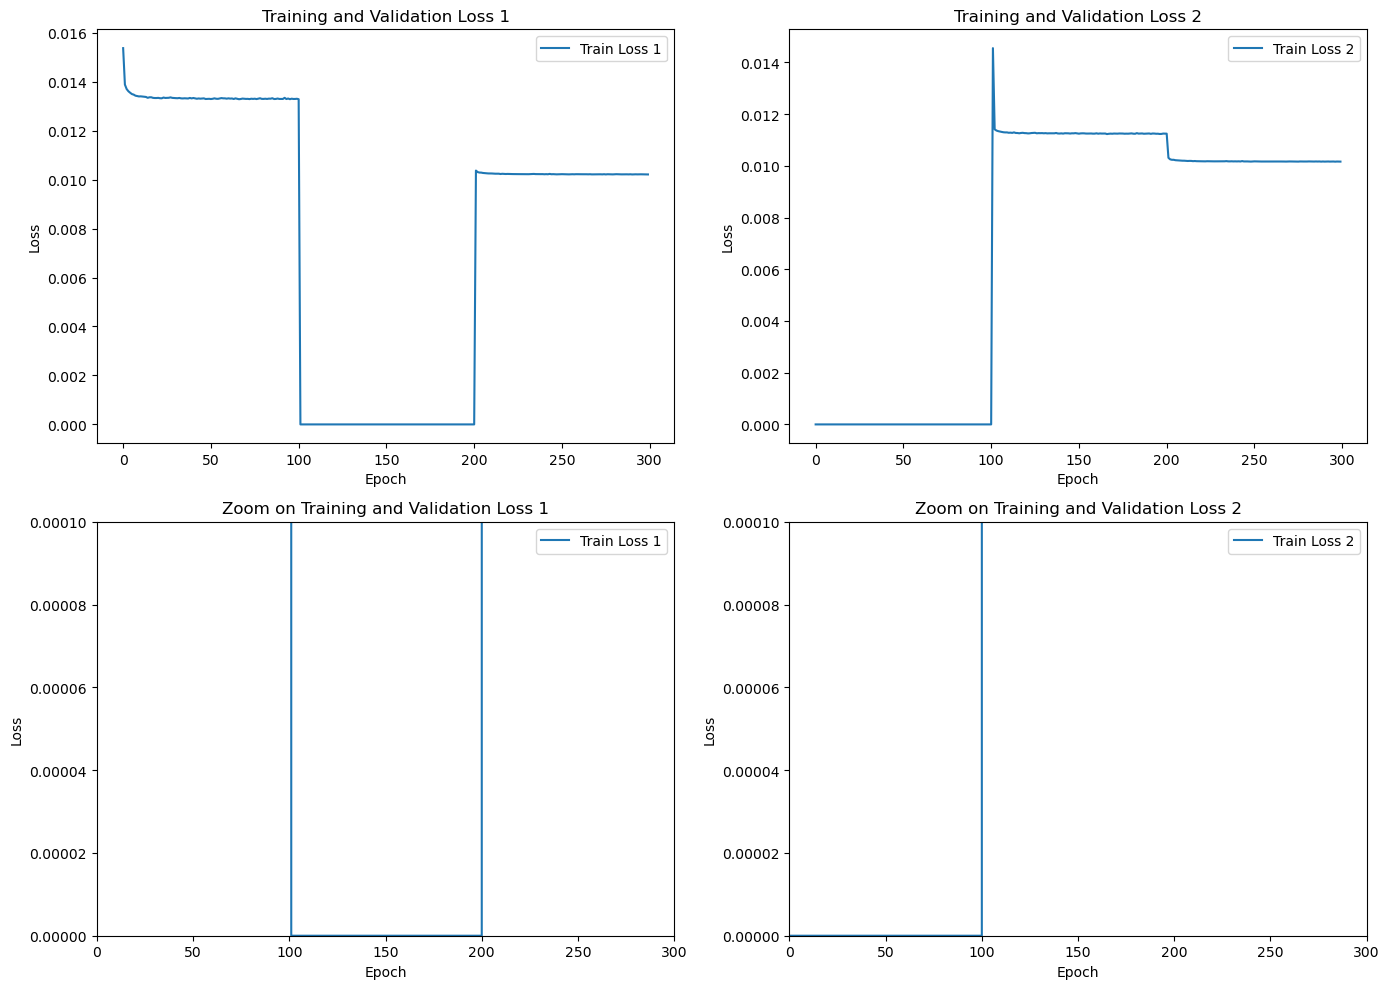

In [37]:
plot_losses(num_epochs, train_losses1, train_losses2)

#### Sauvegarder le modèle

In [70]:
torch.save(model, '/data/SSB_ETU/HLAFARGUE/S6JTEX/neural_networkmodel_real_data_alpha_0pt09.pth')

## Prediction

In [71]:
# Calculer les prédictions
pred1_values = []
pred2_values = []
x1_values = []
x2_values = []

# Mettre le modèle en mode évaluation
model.eval()
with torch.no_grad():
    for batch in loader: #test_loader:
          X1 = batch['X1']
          X2 = batch['X2']
          # Prédiction de X1 et X2 normalisées
          pred1, pred2 = model(X1,X2)
          pred1_values.append(pred1)
          pred2_values.append(pred2)
          # Remettre les prédictions à l'échelle d'origine
          x1_values.append(X1 * scale_1 + mean_1)
          x2_values.append(X2 * scale_2 + mean_2)

# Convertir les listes en arrays
pred1_values = np.concatenate(pred1_values)
pred2_values = np.concatenate(pred2_values)
x1_values = np.concatenate(x1_values)
x2_values = np.concatenate(x2_values)

In [72]:
# Calculer les différences
true_y = Delta_ssh
diff_y1 = pred1_values - true_y
diff_y2 = pred2_values - true_y

In [73]:
# Comparer les prédictions aux vraies valeurs
accuracy1 = np.mean(np.isclose(pred1_values, true_y, atol=0.001)) * 100
accuracy2 = np.mean(np.isclose(pred2_values, true_y, atol=0.001)) * 100
print(f'Accuracy1: {accuracy1:.2f} %')
print(f'Accuracy2: {accuracy2:.2f} %')

Accuracy1: 0.37 %
Accuracy2: 0.10 %


In [74]:
# Tracer les prédictions et les différences
def plot_predictions_and_differences(x1_values, pred_y1, true_y1, diff_y1, x2_values, pred_y2, true_y2, diff_y2):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # Fixer les limites de l'échelle
    vmin, vmax = -0.35, 0
    diff_min, diff_max = -0.05, 0.05

    # Saturer les valeurs des prédictions et des différences
    pred_y1_clipped = np.clip(pred_y1, vmin, vmax)
    pred_y2_clipped = np.clip(pred_y2, vmin, vmax)
    diff_y1_clipped = np.clip(diff_y1, diff_min, diff_max)
    diff_y2_clipped = np.clip(diff_y2, diff_min, diff_max)

    # Définir les niveaux pour les contours
    pred_levels = np.linspace(vmin, vmax, 15)
    diff_levels = np.linspace(diff_min, diff_max, 15)

    # Prédictions phi1
    cnf1 = axs[0, 0].tricontourf(x1_values[:,0], x1_values[:,1], pred_y1_clipped.ravel(), levels=pred_levels, cmap='viridis', vmin=vmin, vmax=vmax)
    cn1 = axs[0, 0].tricontour(x1_values[:,0], x1_values[:,1], pred_y1_clipped.ravel(), levels=pred_levels, linewidths=0.5, colors='white')
    cbar1 = fig.colorbar(cnf1, ax=axs[0, 0])
    cbar1.set_ticks(np.linspace(vmin, vmax, num=8))
    cbar1.set_ticklabels([f"{x:.2f}" for x in np.linspace(vmin, vmax, num=8)])
    axs[0, 0].set_xlabel('WS')
    axs[0, 0].set_ylabel('SWH')
    axs[0, 0].set_title('Prédictions phi1')

    # Différences phi1
    cnf2 = axs[0, 1].tricontourf(x1_values[:,0], x1_values[:,1], diff_y1_clipped.ravel(), levels=diff_levels, cmap='coolwarm', vmin=diff_min, vmax=diff_max)
    cn2 = axs[0, 1].tricontour(x1_values[:,0], x1_values[:,1], diff_y1_clipped.ravel(), levels=diff_levels, linewidths=0.5, colors='white')
    cbar2 = fig.colorbar(cnf2, ax=axs[0, 1])
    cbar2.set_ticks(np.linspace(diff_min, diff_max, num=8))
    cbar2.set_ticklabels([f"{x:.2f}" for x in np.linspace(diff_min, diff_max, num=8)])
    axs[0, 1].set_xlabel('WS')
    axs[0, 1].set_ylabel('SWH')
    axs[0, 1].set_title('Différences entre les prédictions phi1 et les valeurs réelles')

    # Prédictions phi2
    cnf3 = axs[1, 0].tricontourf(x2_values[:,0], x2_values[:,1], pred_y2_clipped.ravel(), levels=pred_levels, cmap='viridis', vmin=vmin, vmax=vmax)
    cn3 = axs[1, 0].tricontour(x2_values[:,0], x2_values[:,1], pred_y2_clipped.ravel(), levels=pred_levels, linewidths=0.5, colors='white')
    cbar3 = fig.colorbar(cnf3, ax=axs[1, 0])
    cbar3.set_ticks(np.linspace(vmin, vmax, num=8))
    cbar3.set_ticklabels([f"{x:.2f}" for x in np.linspace(vmin, vmax, num=8)])
    axs[1, 0].set_xlabel('WS')
    axs[1, 0].set_ylabel('SWH')
    axs[1, 0].set_title('Prédictions phi2')

    # Différences phi2
    cnf4 = axs[1, 1].tricontourf(x2_values[:,0], x2_values[:,1], diff_y2_clipped.ravel(), levels=diff_levels, cmap='coolwarm', vmin=diff_min, vmax=diff_max)
    cn4 = axs[1, 1].tricontour(x2_values[:,0], x2_values[:,1], diff_y2_clipped.ravel(), levels=diff_levels, linewidths=0.5, colors='white')
    cbar4 = fig.colorbar(cnf4, ax=axs[1, 1])
    cbar4.set_ticks(np.linspace(diff_min, diff_max, num=8))
    cbar4.set_ticklabels([f"{x:.2f}" for x in np.linspace(diff_min, diff_max, num=8)])
    axs[1, 1].set_xlabel('WS')
    axs[1, 1].set_ylabel('SWH')
    axs[1, 1].set_title('Différences entre les prédictions phi2 et les valeurs réelles')

    plt.tight_layout()
    plt.show()

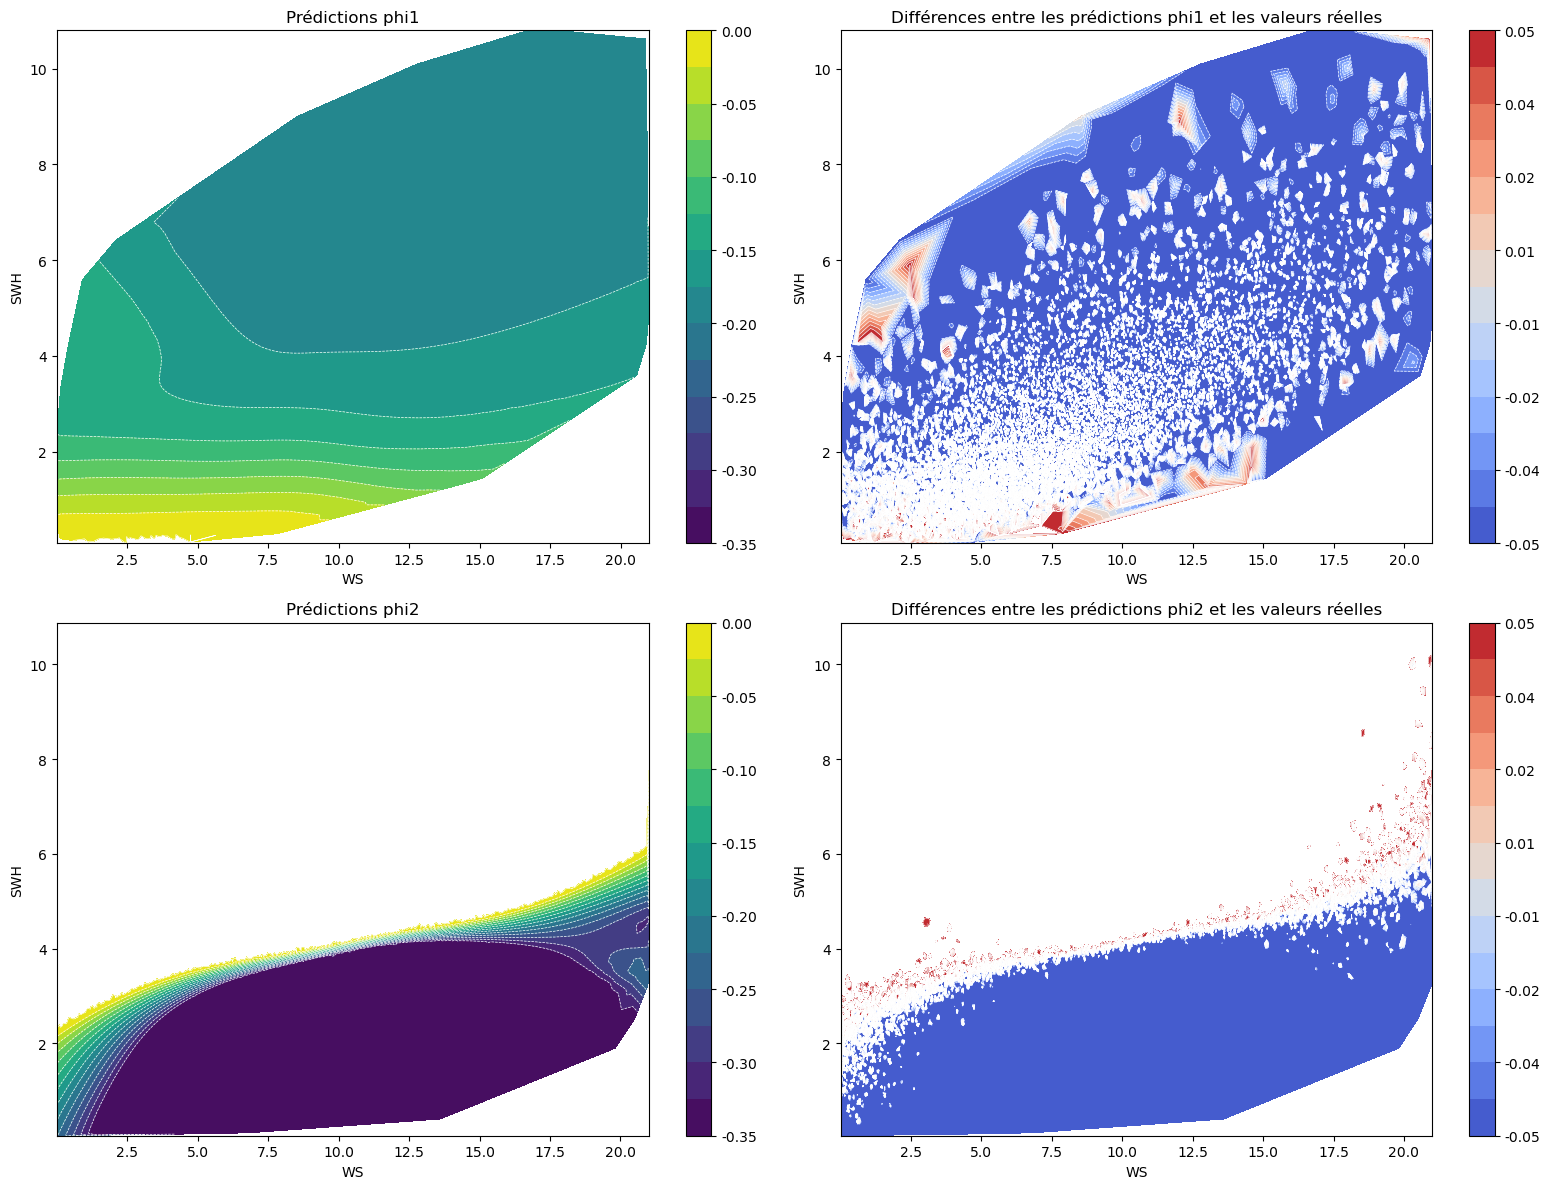

In [75]:
plot_predictions_and_differences(x1_values, pred1_values, true_y, diff_y1, x2_values, pred2_values, true_y, diff_y2)